# Reload & Explore Local NWB Data

This notebook loads a NWB file that has been created for a local dataset, and explores it, with some basic proof-of-concept analyses. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

## Load File

In [3]:
# Read in an local data NWB file
io = NWBHDF5IO('nwb_local_data.nwb', 'r')
nwbfile = io.read()

In [4]:
nwbfile

root pynwb.file.NWBFile at 0x140383503725328
Fields:
  acquisition: {
    field_data <class 'pynwb.ecephys.ElectricalSeries'>,
    position <class 'pynwb.behavior.Position'>
  }
  devices: {
    RECORDING DEVICE <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Example conversion to NWB format.
  experimenter: ['XX']
  file_create_date: [datetime.datetime(2021, 3, 31, 16, 27, 40, 562414, tzinfo=tzoffset(None, -14400))]
  identifier: XX
  institution: Columbia
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: U01 Group
  processing: {
    position_measures <class 'pynwb.base.ProcessingModule'>
  }
  session_description: XX
  session_id: 001
  session_start_time: 2021-03-31 16:27:40.561797-04:00
  stimulus: {
    chest_positions <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at

## Check Position Data

In [5]:
# Check the position data store
nwbfile.acquisition['position']

position pynwb.behavior.Position at 0x140383503920768
Fields:
  spatial_series: {
    xy_pos <class 'pynwb.behavior.SpatialSeries'>
  }

In [6]:
# Grab the position data
pos = nwbfile.acquisition['position']['xy_pos']

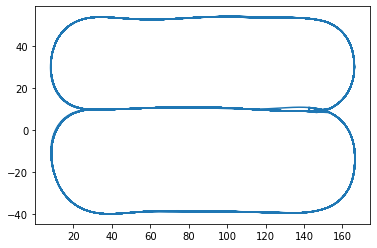

In [7]:
# Plot the map across all position traces
plt.plot(*pos.data)

In [8]:
# Extract position data
x_data = pos.data[0, :]
y_data = pos.data[1, :]

In [9]:
# Check position ranges
print('x data range: {:6.2f} - {:6.2f}'.format(np.min(x_data), np.max(x_data)))
print('y data range: {:6.2f} - {:6.2f}'.format(np.min(y_data), np.max(y_data)))

x data range:   8.19 - 166.46
y data range: -40.09 -  54.27


## Field Data

In [10]:
# Check field data
nwbfile.acquisition['field_data']

field_data pynwb.ecephys.ElectricalSeries at 0x140383503917648
Fields:
  comments: ...
  conversion: 1.0
  data: <HDF5 dataset "data": shape (1, 1797825), type "<f8">
  description: ...
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  rate: 1000.0
  resolution: inf
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts

In [11]:
# Check size of the field data
nwbfile.acquisition['field_data'].data.shape

(1, 1797825)

In [12]:
# Grab a few values from the field data
#   Unclear why are currently two levels of index
nwbfile.acquisition['field_data'].data[0][0:10]

array([  0.58578331,  -0.59403631,  21.57869578,  13.22825244,
        59.3795271 , 106.49539944, 117.223412  ,  90.71552974,
        38.56281563,  39.92339033])

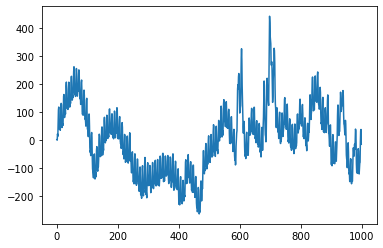

In [13]:
# Plot one second of the recorded field data
plt.plot(nwbfile.acquisition['field_data'].data[0][0:1000])

## Units Data

In [14]:
nwbfile.units

units pynwb.misc.Units at 0x140383504108656
Fields:
  colnames: ['spike_times' 'electrodes' 'waveform_mean']
  columns: (
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>,
    waveform_mean <class 'hdmf.common.table.VectorData'>
  )
  description: Autogenerated by NWBFile
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [15]:
# Pull out all the spike times from NWB file
spike_times = nwbfile.units.spike_times

In [16]:
# Check how many units are in the file
n_units = len(nwbfile.units)
print(n_units)

16


In [17]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(spike_times.shape[0]))

Total number of spikes: 183661


#### Check Unit of Interest

In [18]:
# Set index
uind = 0

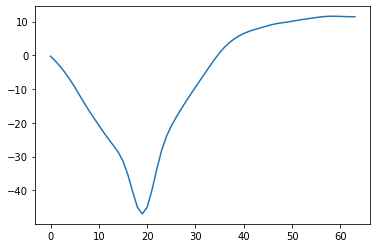

In [19]:
# Plot waveform from unit of interest
plt.plot(nwbfile.units['waveform_mean'][uind, :])

In [20]:
# Grab spikes for requested unit
u0_spikes = nwbfile.units.get_unit_spike_times(uind)
print(u0_spikes[0:3])

[ 1139.93713312 15112.58370861 15118.71706239]


## Example Spatial Firing Analysis

In [21]:
def get_spike_time_range(spikes, tmin, tmax):
    """Extract spike times for a particular time range."""
    
    return spikes[np.squeeze(np.logical_and([spikes > tmin], [spikes < tmax]))]


def get_spike_locations(spikes, pos):
    """Get spike activity across binned locations.
    
    spikes : 1d array
    pos : pynwb.behavior.SpatialSeries
    """

    xs = pos.data[0, :]
    ys = pos.data[1, :]
    
    x_counts, x_bins = np.histogram(xs, bins=15)
    y_counts, y_bins = np.histogram(ys, bins=10)
    
    n_xbins = len(x_bins)-1
    n_ybins = len(y_bins)-1

    out = np.zeros([n_xbins, n_ybins])
    
    for xbin_ind in range(n_xbins):

        in_xbin = np.logical_and(xs > x_bins[xbin_ind], xs < x_bins[xbin_ind + 1])
        
        for ybin_ind in range(n_ybins):
            
            in_ybin = np.logical_and(ys > y_bins[ybin_ind], ys < y_bins[ybin_ind + 1])
            
            in_bin = np.logical_and(in_xbin, in_ybin)
                
            wheres = np.where(np.diff(in_bin))[0]

            bin_spikes = 0
            bin_time = 0    
            for ind in wheres[:-1]:

                t_start = pos.timestamps[ind]
                t_stop = pos.timestamps[ind + 1]

                bin_spikes += len(get_spike_time_range(spikes, t_start, t_stop))
                bin_time += (t_stop - t_start) / 1000
            
            if bin_time != 0:
                out[xbin_ind, ybin_ind] = bin_spikes / bin_time
                
    out[out == 0.] = np.nan
    
    return out

### Anlyze Unit of Interest

In [22]:
# Get spikes for unit of interest
s_ind = 5
spikes = nwbfile.units.get_unit_spike_times(s_ind)

In [23]:
# Get the mapping of spike rate across positions
arr = get_spike_locations(spikes, pos)

In [24]:
print('Min / Max Firing Rate: {:1.2f}, {:1.2f}'.format(np.nanmin(arr), np.nanmax(arr)))
print(np.nanmedian(arr))
print(np.nanmean(arr))

Min / Max Firing Rate: 1.29, 10.91
3.439732267869471
3.8795048611232543


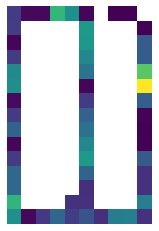

In [25]:
plt.imshow(arr)
plt.axis('off');

### Run Analysis Across all units

In [26]:
# for s_ind in range(len(nwbfile.units)):
#     spikes = nwbfile.units.get_unit_spike_times(s_ind)
#     arr = get_spike_locations(spikes, pos)
#     plt.figure()
#     plt.imshow(arr)
#     plt.axis('off');
#     plt.title('{} : {:1.4}, {:1.4}'.format(s_ind, np.nanmin(arr), np.nanmax(arr)))

## Analysis: Button Press Raster

A quick analysis looking at spiking around an event of interest: the button press.

In [27]:
def compute_spike_diffs(spike_times, trial_times, window=1, return_diff=True):
    """Compute the average difference in spike firing pre vs post time point of interest."""
    
    spike_diffs = []
    spikes = []
    for trial_time in trial_times:
    
        pre_spikes = get_spike_time_range(spike_times, trial_time-window, trial_time)
        post_spikes = get_spike_time_range(spike_times, trial_time, trial_time+window)

        spikes.append(np.hstack([pre_spikes - trial_time, post_spikes  - trial_time]))
        spike_diffs.append(len(post_spikes) - len(pre_spikes))
        
    if return_diff:
        return np.mean(spike_diffs)
    return spikes


def spike_trial_comparison(nwbfile, events, window=1):
    """Compare spiking across units for an event of interest."""
    
    spike_diffs = {}
    for spike_ind in range(len(nwbfile.units)):
    
        spikes = nwbfile.units.get_unit_spike_times(spike_ind)
        spike_diff = compute_spike_diffs(spikes, events, window=window)
        spike_diffs['unit_' + str(spike_ind)] = spike_diff
    
    return spike_diffs


def plot_trial_rasters(data, line=0, xlim=None, figsize=None, axis=False):
    """Plot rasters across multiple trials."""
    
    _, ax = plt.subplots(figsize=figsize)
    ax.eventplot(data);
    if line is not None:
        ax.vlines(line, -1, len(data), lw=2.5, color='green', alpha=0.5);
    ax.set_xlim(None)
    if not axis:
        ax.set_axis_off();

In [28]:
button_presses = nwbfile.intervals['trials']['button_press_time'][:]
button_presses = button_presses[~np.isnan(button_presses)]

#choice_points = nwbfile.intervals['trials']['choice_point_time'][:]
#choice_points = choice_points[~np.isnan(choice_points)]

In [29]:
window = 500
spike_diffs = spike_trial_comparison(nwbfile, button_presses, window)

In [30]:
min_unit = min(spike_diffs, key=spike_diffs.get)
max_unit = max(spike_diffs, key=spike_diffs.get)

print("Min:  {}  {:5.2f}".format(min_unit, spike_diffs[min_unit]))
print("Max:  {}  {:5.2f}".format(max_unit, spike_diffs[max_unit]))

Min:  unit_3  -0.50
Max:  unit_4   0.67


In [31]:
spike_diffs

{'unit_0': -0.05555555555555555,
 'unit_1': -0.16666666666666666,
 'unit_2': -0.2222222222222222,
 'unit_3': -0.5,
 'unit_4': 0.6666666666666666,
 'unit_5': 0.6111111111111112,
 'unit_6': -0.2222222222222222,
 'unit_7': -0.3333333333333333,
 'unit_8': 0.2777777777777778,
 'unit_9': 0.0,
 'unit_10': -0.1111111111111111,
 'unit_11': -0.3888888888888889,
 'unit_12': -0.4444444444444444,
 'unit_13': 0.5555555555555556,
 'unit_14': -0.16666666666666666,
 'unit_15': -0.2222222222222222}

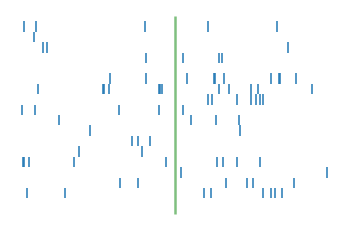

In [32]:
# Compare trial spikes for unit of interest
s_ind = 5
spikes = nwbfile.units.get_unit_spike_times(s_ind)
trial_spikes = compute_spike_diffs(spikes, button_presses, window=window, return_diff=False)
plot_trial_rasters(trial_spikes, xlim=[-window, window])

## Analysis: Raster by space

Analyze rasters of spiking across space.

In [33]:
def get_pos_by_time(timestamps, positions, t_min, t_max):
    """Extract position data for a requested time range."""
    
    select = np.logical_and(timestamps[:] > t_min, timestamps[:] < t_max)
    return timestamps[select], positions[:, select]

def get_pos_by_pos(timestamps, positions, x_range=None, y_range=None):
    """Extract position data for a requested position range."""

    if not x_range:
        x_range = [np.min(positions[0, :]), np.max(positions[1, :])]
    if not y_range:
        y_range = [np.min(positions[1, :]), np.max(positions[1, :])]
        
    x_select = np.logical_and(positions[0, :] > x_range[0], positions[0, :] < x_range[1])
    y_select = np.logical_and(positions[1, :] > y_range[0], positions[1, :] < y_range[1])
    select = np.logical_and(x_select, y_select)
        
    return timestamps[select], positions[:, select]

def get_spike_pos(spikes, timestamps, positions):
    """Get positions for a set of spikes."""
    
    spike_pos = []
    for spike in spikes:
        spike_pos.append(positions[:, np.abs(timestamps - spike).argmin()])
    return spike_pos

### Position Data for a Single Trial

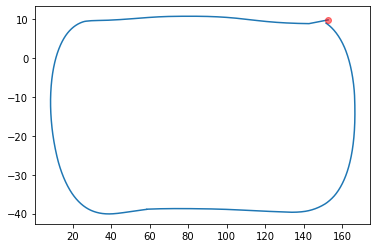

In [34]:
t_ind = 10
_, trial_pos = get_pos_by_time(pos.timestamps, pos.data,
                               nwbfile.trials.start_time[t_ind],
                               nwbfile.trials.stop_time[t_ind])

plt.plot(*trial_pos)
plt.plot(*trial_pos[:, 0], '.r', ms=12, alpha=0.5)

### XXX

In [35]:
#x_range = [100, 140]
x_range = [20, 150]
y_range = [-50, -25]
#y_range = [40, 60]

In [36]:
ts, ps = get_pos_by_pos(pos.timestamps, pos.data, x_range, y_range)

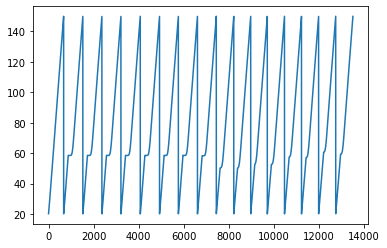

In [37]:
plt.plot(ps[0, :])

In [38]:
# Get spikes for unit of interest
s_ind = 5
spikes = nwbfile.units.get_unit_spike_times(s_ind)

In [39]:
# ....
t_outs, p_outs = [], []
for t_ind in range(len(nwbfile.trials)):
    trial_ts, trial_ps = get_pos_by_time(pos.timestamps, pos.data,
                                         nwbfile.trials.start_time[t_ind],
                                         nwbfile.trials.stop_time[t_ind])
    
    cur_ts, cur_ps = get_pos_by_pos(trial_ts, trial_ps, x_range, y_range)
    t_outs.append(cur_ts)
    p_outs.append(cur_ps)

In [40]:
# ....
trial_pos_spikes = []
for t_times in t_outs:
    if len(t_times) > 2:
        cur_spikes = get_spike_time_range(spikes, t_times[0], t_times[-1])
        cur_spike_pos = get_spike_pos(cur_spikes, pos.timestamps, pos.data)
        trial_pos_spikes.append(cur_spike_pos)
        
trial_pos_spikes = [[val[0] for val in middle] for middle in trial_pos_spikes]

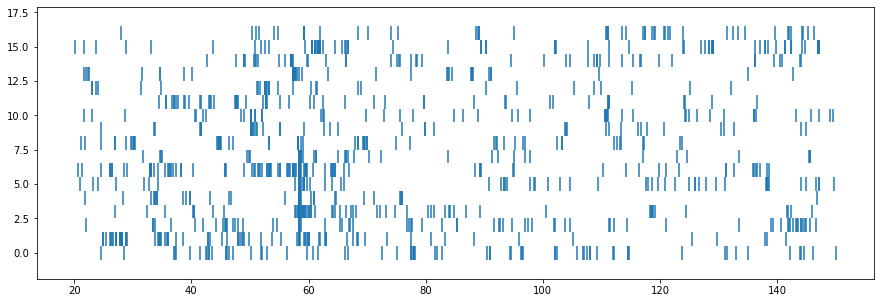

In [42]:
plot_trial_rasters(trial_pos_spikes, line=None, figsize=(15, 5), axis=True)

### Close File

In [ ]:
io.close()